In [46]:
### 05-15 copied from DIBModeling/01-18_MCMCmodel.ipynb

import numpy as np

import astropy.units as u  
import astropy.constants as c
import emcee

import matplotlib.pyplot as plt
import matplotlib 
import corner

from itertools import product

import sys
import os
import tqdm

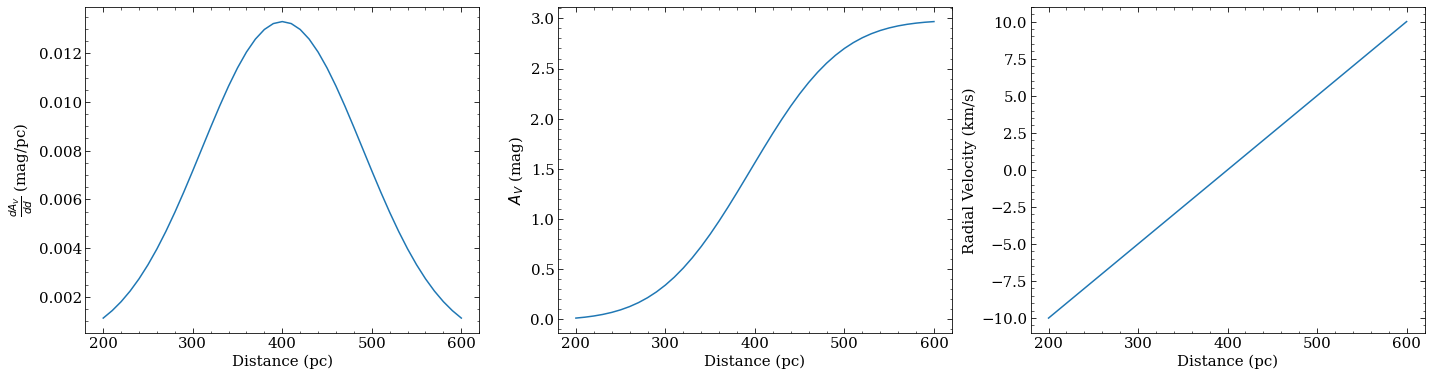

In [47]:
lambda0 = 15272.42 
sigma0 = 2

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

### Cloud simulation functions ###

d0 = 400            # Cloud center
w0 = 50             # Cloud width (stdev)
Av_max = 3          # Maximum extinction
vavg = 0            # Average cloud radial velocity
vdiff = 5           # Max velocity offset from vavg


def Differential_Av(d, d0 = d0, w0 = w0, Av_Max = Av_max):
    A = Av_max / (np.sqrt(2 * np.pi) * w0) 
    return A * np.exp(-(d - d0)**2 / (2 * w0**2))

def Av(d, **kwargs): 
    dd = d[1]-d[0]
    return np.cumsum(Differential_Av(d, **kwargs)) * dd

# def Radial_Velocity(d, d0 = d0, vavg = vavg, vdiff = vdiff):
#     dd = d[1]-d[0]
#     dispersion = 10 * np.abs(vdiff)
#     dv_dd =  1 / (np.sqrt(2 * np.pi) * dispersion)  * np.exp(-(d-d0)**2 / (2 * dispersion**2))
#     return 2 * vdiff * np.cumsum(dv_dd) * dd + vavg - vdiff

vclose = -5
vfar = 5
def Radial_Velocity(d, dclose = 200, dfar = 600, vclose = vclose, vfar = vfar):
    dd = d[1]-d[0]
    m = (vfar - vclose) / (dfar - dclose)
    return m * (d - dclose) + vclose


### DIB amplitiude per dAV/dd ###
# From Zasowksi+2015

def Differential_Amplitude(dAv_dd, dd):
     return 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd


### Model cloud visualization ###

distance = np.arange(200, 601, 10)

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 6))
axs[0].plot(distance, Differential_Av(distance, w0 = 90))
axs[0].set_xlabel('Distance (pc)')
axs[0].set_ylabel(r'$\frac{dA_V}{dd}$ (mag/pc)')

axs[1].plot(distance, Av(distance, w0 = 80))
axs[1].set_xlabel('Distance (pc)')
axs[1].set_ylabel('$A_V$ (mag)')


axs[2].plot(distance, Radial_Velocity(distance, vclose = -10, vfar = 10))
axs[2].set_xlabel('Distance (pc)')
axs[2].set_ylabel('Radial Velocity (km/s)')
fig.set_facecolor('white')

plt.show()

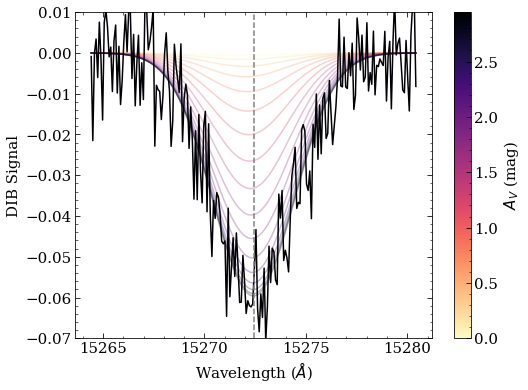

In [65]:
### DIB signal generation ###
spec_res = 200
wavs = np.linspace(lambda0-8, lambda0+8, spec_res)

dd = 25
voxel_dist = np.arange(200, 601, dd)
# star_dist = voxel_dist
voxel_dAv_dd = Differential_Av(voxel_dist, w0 = 90)
# star_dAv_dd = voxel_dAv_dd

v_max = 10
voxel_rvelo = Radial_Velocity(voxel_dist, vclose = -v_max, vfar = v_max)
# voxel_rvelo = Radial_Velocity(voxel_dist)#, vclose = -7.5, vfar = 7.5)

def make_signals(rvelo, dAv_dd = voxel_dAv_dd, dist = voxel_dist, **kwargs):
    signals = np.zeros((len(dist), spec_res))
    amp = Differential_Amplitude(dAv_dd, dd = dd)

    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs, (len(dist), 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))

    def single_signal(dist_max, dist = voxel_dist, amp = amp, sigma0 = sigma0):
        amp = -amp.copy()
        amp[dist > dist_max] = 0
        voxel_DIB_scaled = voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        return summed_DIB 
    
    for i in range(len(dist)):
        dist_max = dist[i]
        signals[i, :] = single_signal(dist_max, dist = dist)
    return signals

signals = make_signals(voxel_rvelo)


fig, ax = plt.subplots(figsize = (8,6))


normalize = matplotlib.colors.Normalize(0, np.max(np.cumsum(voxel_dAv_dd * dd)))
cmap = matplotlib.cm.magma_r
cmappable = matplotlib.cm.ScalarMappable(norm = normalize, cmap = cmap)
colors = cmap(np.linspace(0,1,len(signals)))

for i in range(len(signals)):
    ax.plot(wavs[:, np.newaxis], signals[i, :], color = colors[i] , alpha = 0.3)
ax.plot(wavs, signals[-1, :] + + np.random.normal(0, 1/120, size = len(wavs)), color = colors[-1])
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('DIB Signal')
fig.colorbar(cmappable, label = '$A_V$ (mag)')
ax.set_ylim(-0.07, 0.01,)
ax.plot((lambda0, lambda0), ax.get_ylim(), color = 'grey', linestyle = 'dashed')
fig.set_facecolor('white')
plt.show()

In [66]:
theoretical_DIB_amp = 102e-3 * np.max(Av(voxel_dist)) / (np.sqrt(2 * np.pi) * sigma0)
print(theoretical_DIB_amp)
print(voxel_dist)

0.06103709557510069
[200 225 250 275 300 325 350 375 400 425 450 475 500 525 550 575 600]


In [67]:
SNR = 200

true_signal = make_signals(rvelo = voxel_rvelo)
added_noise = np.random.normal(0, 1/SNR, true_signal.shape) #sigma = 1/SNR
noisy_signal = true_signal + added_noise


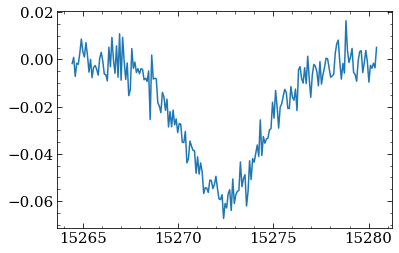

In [68]:
# for i in range(17):
plt.plot(wavs, noisy_signal[16, :])
plt.show()

In [69]:
noisy_signal.shape

(17, 200)

In [82]:
dist_bins = [(150, 300), (300, 460), (450, 600)]

dist_med = np.zeros(len(dist_bins))
dAVdd_med = np.zeros(len(dist_bins))
rvelo_med = np.zeros(len(dist_bins))
signal_med = np.zeros((len(dist_bins), noisy_signal.shape[1]))


for i in range(len(dist_bins)):
    bin_min, bin_max = dist_bins[i]
    dist_window = (voxel_dist > bin_min) & (voxel_dist <= bin_max)
    dist_med[i] = np.nanmedian(voxel_dist[dist_window])
    dAVdd_med[i] = np.nanmedian(voxel_dAv_dd[dist_window])
    rvelo_med[i] = np.nanmedian(voxel_rvelo[dist_window])
    signal_med[i, :] = np.nanmedian(noisy_signal[dist_window, :], axis = 0)


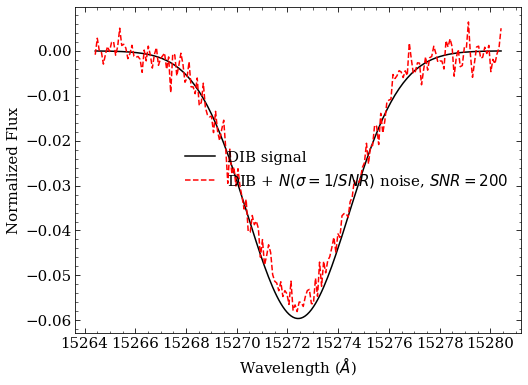

In [83]:
fig, ax = plt.subplots(figsize= (8,6))
ax.plot(wavs, signals[-1, :] , label = 'DIB signal', color='k')

ax.plot(wavs, signal_med[-1, :] , color = 'r', linestyle = 'dashed', label = 'DIB + $N(\sigma =1/SNR)$ noise, $SNR = {}$'.format(SNR))
ax.set_xlabel("Wavelength ($\AA$)")
ax.set_ylabel("Normalized Flux")
fig.set_facecolor('white')
ax.legend()
plt.show()

In [108]:


def loglikely(v, snr = SNR, signal = signal_med, **kwargs):
    return - 0.5 * np.sum((signal - make_signals(v, **kwargs))**2 / (1/snr**2)) 

def logprior(v, v_max = 5, prior_mult = 1, **kwargs):
    if (np.any(np.abs(v) > prior_mult * v_max)):
        return -np.inf
    return 0.0

def logprob(v, logprior = logprior, loglikely = loglikely, **kwargs):
    lp = logprior(v, **kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + loglikely(v, **kwargs)

In [114]:
nwalkers = 100
ndim = len(dist_med)
prior_mult = 2

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, 
                                kwargs  = {'prior_mult':  prior_mult, 'v_max': v_max, 'snr': SNR,
                                           'dAv_dd': dAVdd_med, 'dist': dist_med})
# init =  np.tile(voxel_rvelo, nwalkers).reshape((nwalkers, ndim)) + np.random.normal(0, 1/np.sqrt(SNR), (nwalkers, ndim))
init = 2 * prior_mult * v_max * (np.random.random((nwalkers, ndim)) - 0.5)

In [115]:
steps = 1000
sampler.run_mcmc(init, steps);

In [113]:
# chain = sampler.chain[0, :, :].reshape(-)

In [88]:
# chain = sampler.chain[0, :, :].reshape((-1, len(voxel_rvelo)))
# fig, ax  = plt.subplots(figsize = (16, 6))
# select = int(len(voxel_rvelo)/2)
# ax.plot(chain[:, select], alpha = 0.8)
# ax.plot(ax.get_xlim(), (voxel_rvelo[select], voxel_rvelo[select]))
# ax.set_xlabel('Walker steps?')
# plt.show()


In [89]:
sampler.chain.shape

(100, 3000, 3)

In [116]:
nwalkers = 100
ndim_old = len(voxel_dist)
prior_mult = 2

sampler_old = emcee.EnsembleSampler(nwalkers, ndim_old, logprob, 
                                kwargs  = {'prior_mult':  prior_mult, 'v_max': v_max, 'snr': SNR,
                                           'dAv_dd': voxel_dAv_dd, 'dist': voxel_dist, 'signal': noisy_signal})
# init =  np.tile(voxel_rvelo, nwalkers).reshape((nwalkers, ndim)) + np.random.normal(0, 1/np.sqrt(SNR), (nwalkers, ndim))
init_old = 2 * prior_mult * v_max * (np.random.random((nwalkers, ndim_old)) - 0.5)

In [117]:
steps = 1000
sampler_old.run_mcmc(init_old, steps);

(3000, 100)
4.158044095131988
-0.4012937965694924
-0.4012937965694924
4.112595289206245


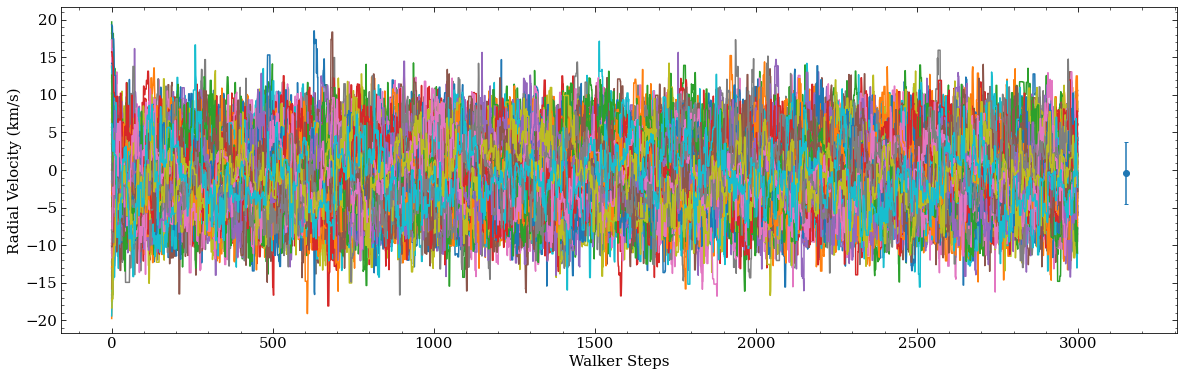

In [90]:
fig, ax = plt.subplots(figsize = (20, 6))

normalize = matplotlib.colors.Normalize(-10, 10)
cmap = matplotlib.cm.viridis
cmappable = matplotlib.cm.ScalarMappable(norm = normalize, cmap = cmap)
colors = cmap(np.linspace(0,1,ndim))

# for i in range(ndim):
# i = int(17/2) 
i = -1
walkers = sampler.chain[:,:,i].T
print(walkers.shape)
points = ax.plot(walkers)

cutoff = 100
median = np.median(walkers[100:, :])
perc16err =  median - np.percentile(walkers[100:, :], 16) 
perc84err =  np.percentile(walkers[100:, :], 84) - median
stdeviation =  np.std(walkers[100,:], ddof = 1)
print(perc16err)
print(median)
print(median)
print(perc84err)


plt.errorbar(x = steps + 0.05 * steps, y = median, yerr = stdeviation, fmt = 'o', capsize = 2)

# fig.colorbar(cmappable, label = 'Velocity ')
ax.set_xlabel("Walker Steps")
ax.set_ylabel('Radial Velocity (km/s)')
plt.show()


In [91]:
labels = ['{} pc'.format(i) for i in voxel_dist]
# print(labels)
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
# fig = corner.corner(samples, truths = voxel_rvelo, labels = labels, figsize = (20, 20))
# # for ax in fig.axes:
#     # ax.set_xlim(-10, 10)
#     # ax.set_ylim(-20, 20) 
# plt.show()

In [118]:
samples_old = sampler_old.chain[:, 500:, :].reshape((-1, ndim_old))

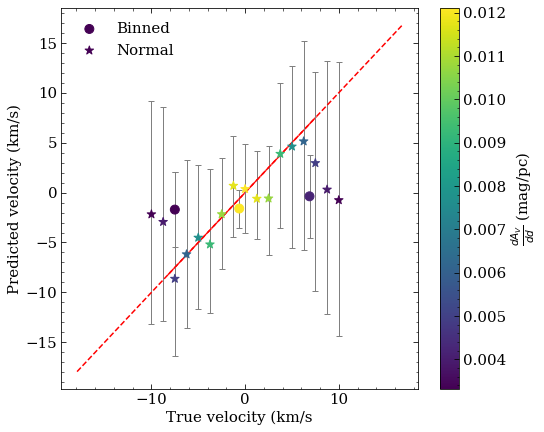

In [142]:
def compare_plot(chain, rvelo = voxel_rvelo, dAV_dd = voxel_dAv_dd, stats = None, label = None, snr = SNR, fig = None, ax = None, marker = 'o'):
    # velocity_mean = np.sum(chain, axis = 0) / chain.shape[0]
    if stats == None:
        velocity_median = np.median(chain, axis = 0)
        perc16 = np.percentile(chain,16, axis = 0)
        perc84 = np.percentile(chain, 84, axis = 0)
    else: 
        velocity_median, perc16, perc84 = stats
    # std = np.std(chain, axis = 0, ddof = 1)

    if fig is None:
        fig, ax = plt.subplots(figsize = (8, 7))
    # ax.set_aspect('equal')
    ax.errorbar(rvelo, velocity_median, xerr = 1/snr, yerr = (np.abs(perc16 - velocity_median), np.abs(perc84 - velocity_median)), capsize = 3, fmt = '.', color = 'grey', linewidth = 1)
    # ax.errorbar(voxel_rvelo, velocity_median, xerr = 1/SNR, yerr = std, fmt = 'o', color = 'grey')

    points = ax.scatter(rvelo, velocity_median, s=80, c = dAV_dd, zorder = 3, label =label , marker = marker, )
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    mini, maxi = (np.min((xmin, ymin)), np.max((xmax, ymax)))

    ax.plot((mini, maxi), (mini, maxi), color = 'red', linestyle = 'dashed')

    ax.set_xlabel('True velocity (km/s')
    ax.set_ylabel('Predicted velocity (km/s)')


    ax.legend()
    return fig, ax, points

# compare_plot(chain)
fig, ax, points  = compare_plot(samples, rvelo = rvelo_med, dAV_dd = dAVdd_med, label = 'Binned')
compare_plot(samples_old, fig = fig, ax = ax, marker = '*', label = 'Normal')

fig.colorbar(points, label = r"$\frac{dA_V}{dd}$ (mag/pc)")
fig.set_facecolor('white')
plt.show()

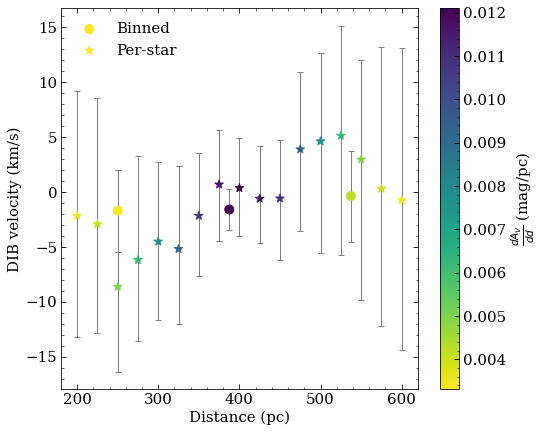

In [144]:
def display_plot(chain, rvelo = voxel_rvelo, dist = voxel_dist, dAV_dd = voxel_dAv_dd, stats = None, label = None, snr = SNR, fig = None, ax= None, marker = 'o'):
    # velocity_mean = np.sum(chain, axis = 0) / chain.shape[0]
    if stats == None:
        velocity_median = np.median(chain, axis = 0)
        perc16 = np.percentile(chain,16, axis = 0)
        perc84 = np.percentile(chain, 84, axis = 0)
    else: 
        velocity_median, perc16, perc84 = stats
    # std = np.std(chain, axis = 0, ddof = 1)

    if fig is None:
        fig, ax = plt.subplots(figsize = (8, 7))
    # ax.set_aspect('equal')
    ax.errorbar(dist, velocity_median, yerr = (np.abs(perc16 - velocity_median), np.abs(perc84 - velocity_median)), capsize = 3, fmt = '.', color = 'grey', linewidth = 1)
    # ax.errorbar(voxel_rvelo, velocity_median, xerr = 1/SNR, yerr = std, fmt = 'o', color = 'grey')


    points = ax.scatter(dist, velocity_median, c = dAV_dd, zorder = 3, label =label, cmap = 'viridis_r' , s=80, marker = marker)


    # ax.plot(dist, rvelo, marker = '+', label = 'True velocity')

    Av_array = Av(voxel_dist, w0 = w0)
    


    def forward(x):
        return np.interp(x, voxel_dist, Av_array)

    def inverse(x):
        return np.interp(x, Av_array, voxel_dist)

    # secax = ax.secondary_xaxis('top', functions=(forward, inverse))
    # secax.set_xlabel('$A_v$ (mag)')
    # secax.set_xticks([0, 0.5,1.5,  2.5, 3])


    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('DIB velocity (km/s)')

    leg = ax.legend()
    # leg.legendHandles[1].set_color(matplotlib.cm.viridis.colors[-1])
    fig.set_facecolor('white')
    return fig, ax, points

fig, ax, points = display_plot(samples, rvelo = rvelo_med, dist = dist_med, dAV_dd = dAVdd_med, label = 'Binned', marker = 'o')

display_plot(samples_old, rvelo = voxel_rvelo, fig = fig, ax = ax, marker = '*', label = 'Per-star')
# fig.savefig('plots_save/SNR{}/run_noavtop.png'.format(SNR), transparent = False)
fig.colorbar(points, label = r"$\frac{dA_V}{dd}$ (mag/pc)")

plt.show()


In [99]:
def voxel_signal(dist = voxel_dist, dAv_dd = voxel_dAv_dd, rvelo = voxel_rvelo, wavs = wavs):
    amp = Differential_Amplitude(dAv_dd, dd = dd)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs, (len(dist), 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    voxel_DIB_scaled = - voxel_DIB_unscaled *  amp[:, np.newaxis] 
    return voxel_DIB_scaled 


def signal_plots(chain, stats = None, rvelo = voxel_rvelo, snr = SNR, title = None):
    if stats == None:
        velocity_median = np.median(chain, axis = 0)
        perc16 = np.percentile(chain,16, axis = 0)
        perc84 = np.percentile(chain, 84, axis = 0)
    else: 
        velocity_median, perc16, perc84 = stats
    
    true_dsignal = voxel_signal(rvelo)
    noisy_dsignal = true_dsignal + np.random.normal(0, 1/SNR, true_signal.shape) 
    model_dsignal_median = voxel_signal(velocity_median)
    model_dsignal_perc16 = voxel_signal(perc16)
    model_dsignal_perc84 = voxel_signal(perc84)

    
    fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (35, 14))
    inds = (len(rvelo) * np.array([0.2, 0.35, 0.5, 0.65, 0.8])).astype(int)

    real_signals = (noisy_dsignal, true_dsignal)
    for n in range(len(real_signals)):
        obs_dsignal = real_signals[n]
        axs[n, 0].set_ylabel('DIB Signal')

        for i in range(len(inds)):
            j = inds[i]
            obslabel = ['Obs w/ noise', 'Obs signal']
            axs[n, i].plot(wavs, model_dsignal_median[j, :], color = 'k', label = 'd = {} pc'.format(voxel_dist[j]))
            axs[n, i].plot(wavs, obs_dsignal[j, :], linestyle = 'dashed', color = 'r', label = obslabel[n])
            axs[n, i].legend()

            axs[1, 2].set_xlabel('Wavelength ($\AA$)')
    
    fig.suptitle(title)
    return fig


# signal_plots(samples)
# plt.show()

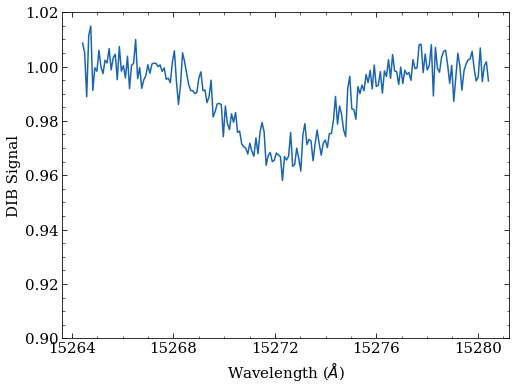

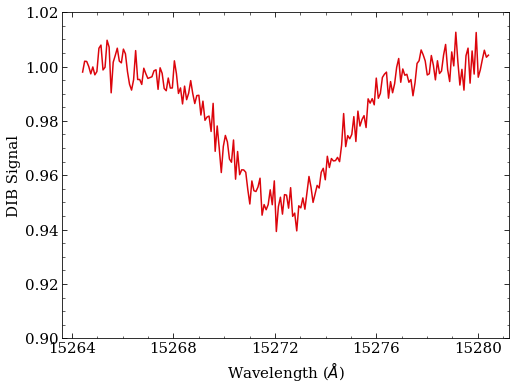

In [100]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(wavs, 1 + noisy_signal[8, :], color = '#1965B0') # purple #'#882E72' blue #1965B0
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('DIB Signal')
xticks = np.arange(15264, 15281, 4)
ax.set_xticks(xticks)
ax.set_ylim(0.9, 1.02)
# fig.savefig('plots_save/SNR{}/DIB8_blue.png'.format(SNR), transparent = False)
plt.show()

fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(wavs, 1 + noisy_signal[12, :], color = "#DC050C") # orange "#E8601C" red #DC050C
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('DIB Signal')
ax.set_xticks(xticks)
ax.set_ylim(0.9, 1.02)
# fig.savefig('plots_save/SNR{}/DIB12_red.png'.format(SNR), transparent = False)

plt.show()

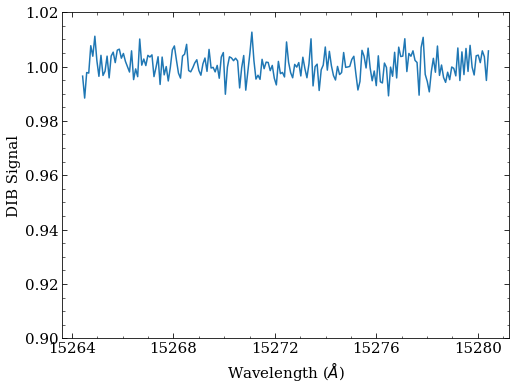

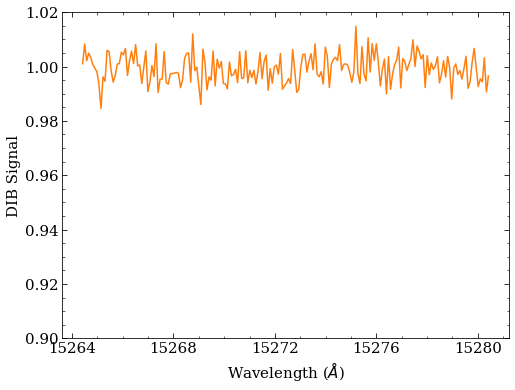

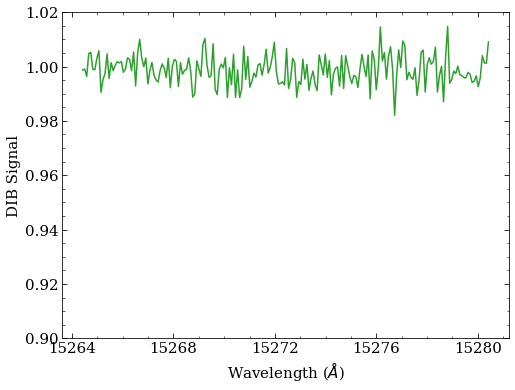

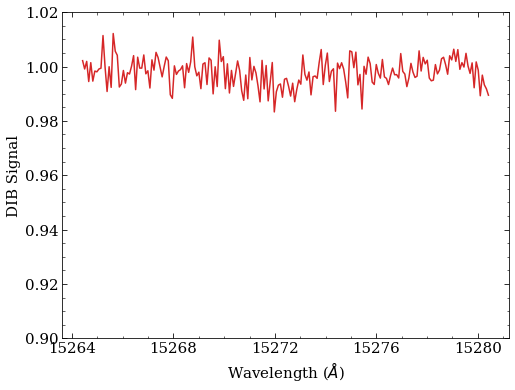

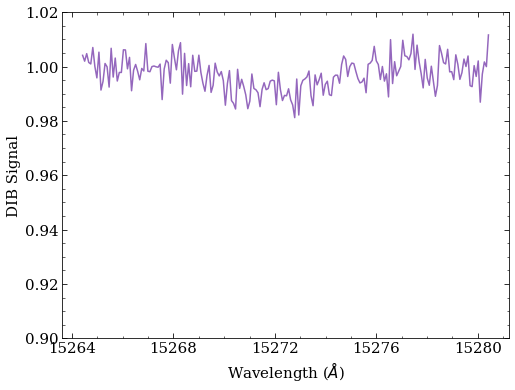

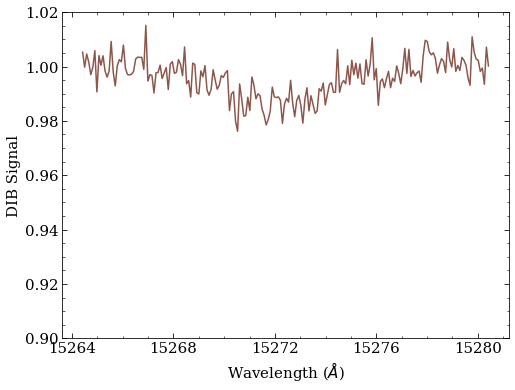

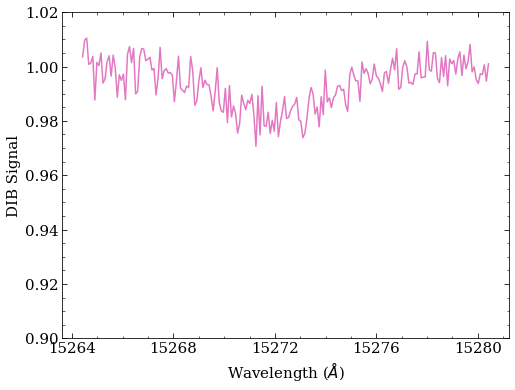

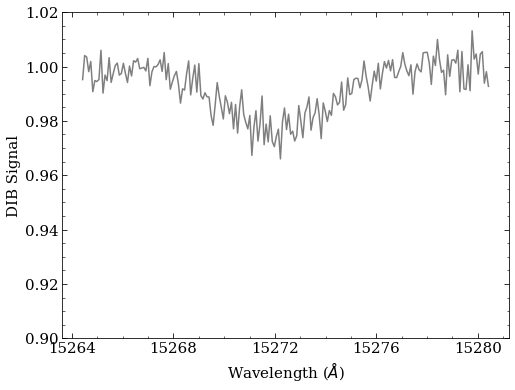

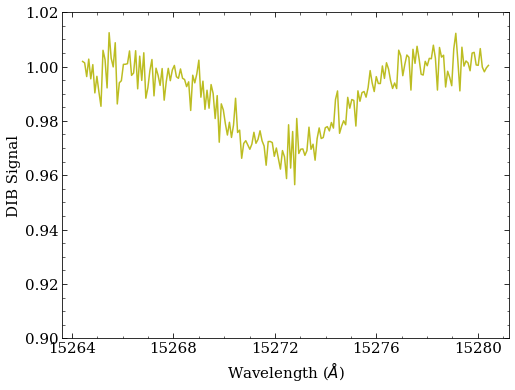

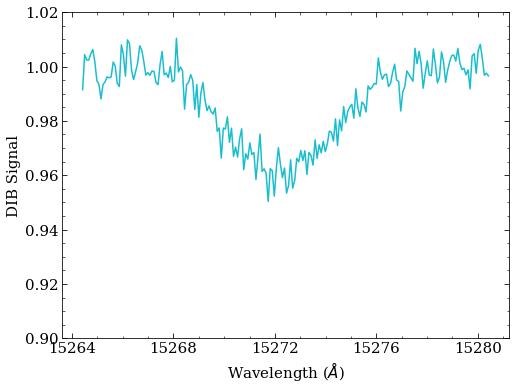

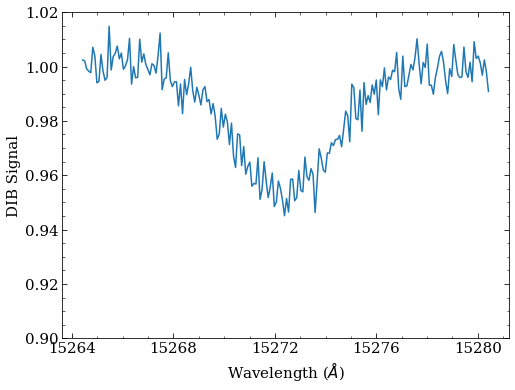

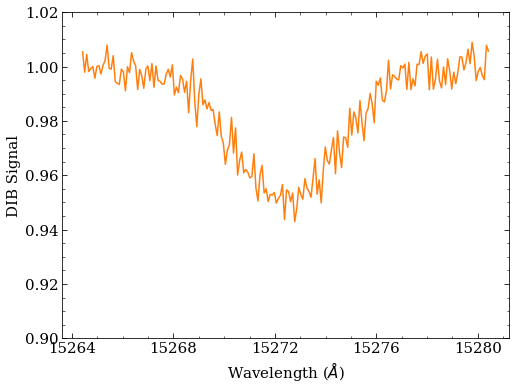

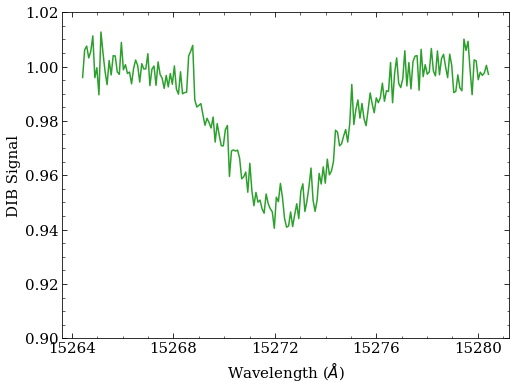

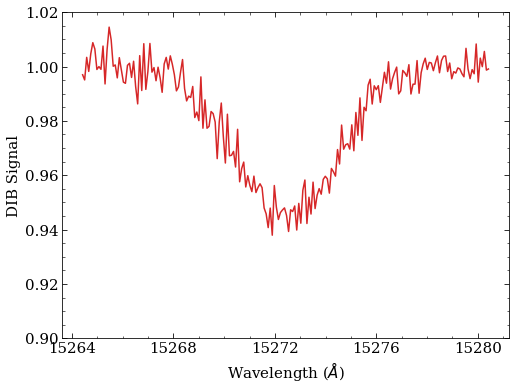

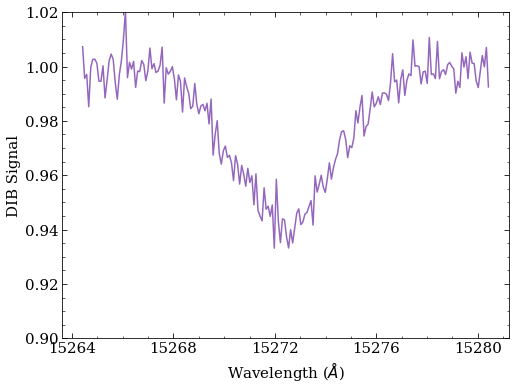

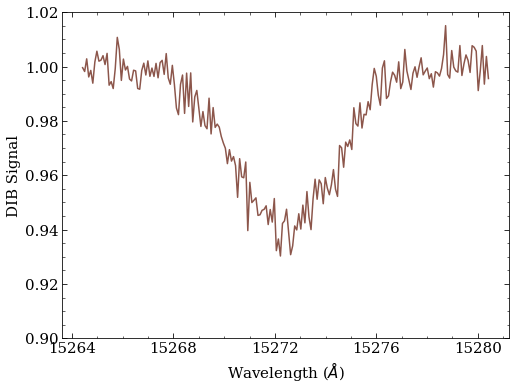

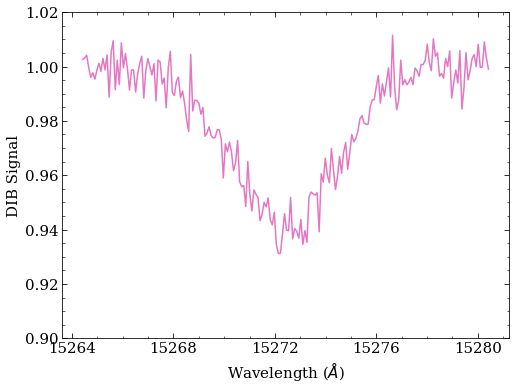

In [ ]:
for i in range(len(voxel_dist)):
    fig, ax = plt.subplots(figsize = (8, 6))
    ax.plot(wavs, 1 + noisy_signal[i, :], color = 'C{}'.format(i))# "#DC050C") # orange "#E8601C" red #DC050C
    ax.set_xlabel('Wavelength ($\AA$)')
    ax.set_ylabel('DIB Signal')
    ax.set_xticks(xticks)
    ax.set_ylim(0.9, 1.02)
    # fig.savefig('plots_save/SNR{s}/DIB{i}.png'.format(s = SNR, i = i), transparent = False)

plt.show()

In [ ]:
# ### test a number of cases ###

# test_SNR = np.array([150, 1.5e5], dtype = 'object')
# # test_vmax = np.array([10., 100.], dtype = 'object')
# test_vmax = np.array([5., 10., 100], dtype = 'object')
# test_prior_mult = np.array([1., 2., 5., np.infty], dtype = 'object')

# param_combos = list(product(test_SNR, test_vmax, test_prior_mult))

# directory = 'MCMC_Outputs/'

# def generate_model_plots(snr, velo, prior_mult):
#     radvelo = Radial_Velocity(voxel_dist, vclose = -velo, vfar = velo)

#     signal = make_signals(rvelo = radvelo)
#     obs_signal = signal+ np.random.normal(0, 1/np.sqrt(snr), true_signal.shape)
#     init =  np.tile(radvelo, nwalkers).reshape((nwalkers, ndim)) + np.random.normal(0, 10/(np.sqrt(snr)), (nwalkers, ndim))

#     sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, kwargs={'true_signal': signal, 'noisy_signal': obs_signal, 'snr': snr, 'prior_mult': prior_mult, 'v_max': velo})
#     sampler.run_mcmc(init, nsteps = 500)
#     chain = sampler.chain[:, 0:, :].reshape((-1, len(voxel_rvelo)))
#     velocity_median = np.median(chain, axis = 0)
#     perc16 = np.percentile(chain,16, axis = 0)
#     perc84 = np.percentile(chain, 84, axis = 0)

#     labels = ['{} pc'.format(i) for i in voxel_dist]
#     corner_figure = corner.corner(chain, truths = radvelo, labels = labels, figsize = (20, 20));

#     stats = (velocity_median, perc16, perc84)
#     info = 'v = {velo}, pmult = {pmult}'.format(velo = velo, pmult = prior_mult)
#     compare_figure = compare_plot(chain, rvelo = radvelo, stats = stats, label = info, snr = snr);

#     signals_figure = signal_plots(chain, stats = stats, rvelo = radvelo, snr = snr, title = info);

#     return (corner_figure, compare_figure, signals_figure)

# for combo in tqdm.tqdm(param_combos, total = len(param_combos)):
#     snr, velo, prior_mult = combo
#     print(snr, velo, prior_mult)

#     snrlabel, vlabel, priorlabel,  = ('snr_{}'.format(snr), 'vmax_{}'.format(velo), 'prior_{}'.format(prior_mult))
#     folder = directory + snrlabel + '/' + vlabel + '/' 
#     if not os.path.exists(folder):
#         os.makedirs(folder)
    

#     corner_figure, compare_figure, signals_figure = generate_model_plots(snr , velo, prior_mult)

#     suffix = 'v{vel}-p{p}.pdf'.format(vel = velo, p = prior_mult)
#     corner_figure.savefig(folder + 'corner'+suffix)
#     compare_figure.savefig(folder + 'comparison' +suffix)
#     signals_figure.savefig(folder + 'signals'+suffix)

#     corner_figure.clear()
#     compare_figure.clear()
#     signals_figure.clear()
#     plt.close('all')



In [ ]:
Av_array = Av(voxel_dist, w0 = w0)


def forward(d):
    return Av(d, w0 = w0)

def inverse(av):
    return np.interp(av, Av_array, voxel_dist)


# forward(voxel_dist)
# inverse(Av_array)

forward(voxel_dist)
inverse(forward(voxel_dist))

# secax = ax.secondary_xaxis('top', functions=(forward, inverse))
# secax.set_xlabel('$A_v$ (mag)')

array([200., 225., 250., 275., 300., 325., 350., 375., 400., 425., 450.,
       475., 500., 525., 550., 575., 600.])